## 1. Image Data Handling

In [1]:
%pylab inline

import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split

from keras.layers import Dense
from keras.models import Sequential
from keras.preprocessing import image
from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16, preprocess_input

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
# To stop potential randomness
seed = 42
rng = np.random.RandomState(seed)

In [3]:
data = pd.read_csv('../datasets/facial_keypoint_identification/facial_keypoint_identification.csv')

In [4]:
data.head()

,image_name,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y
0,0.jpg,66,39,30,36
1,1.jpg,64,34,29,33
2,2.jpg,65,34,30,34
3,3.jpg,65,37,32,37
4,4.jpg,66,39,32,38


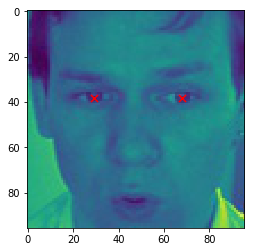

In [5]:
idx = rng.choice(data.index)

fig,ax = plt.subplots(1)
img = imread('../datasets/facial_keypoint_identification/images/' + data.image_name.iloc[idx])
ax.imshow(img,cmap='gray')
ax.scatter(data.left_eye_center_x.iloc[idx], data.left_eye_center_y.iloc[idx], marker='x', s=50, c='r')
ax.scatter(data.right_eye_center_x.iloc[idx], data.right_eye_center_y.iloc[idx], marker='x', s=50, c='r')

plt.show()

## 2. Data Loading and Preprocessing

In [6]:
images = []
for img in data.image_name:
    img = image.load_img('../datasets/facial_keypoint_identification/images/' + img)
    img = image.img_to_array(img)
    images.append(img)
    
images=np.array(images)

In [7]:
img

array([[[ 77.,  35., 117.],
        [ 77.,  49., 126.],
        [ 69.,  62., 130.],
        ...,
        [ 32., 135., 144.],
        [ 44., 127., 143.],
        [ 41., 109., 130.]],

       [[ 73.,  38., 118.],
        [ 72.,  51., 126.],
        [ 64.,  65., 130.],
        ...,
        [ 38., 125., 144.],
        [ 49., 121., 145.],
        [ 45., 105., 133.]],

       [[ 70.,  49., 124.],
        [ 70.,  63., 133.],
        [ 61.,  75., 136.],
        ...,
        [ 44., 113., 142.],
        [ 53., 112., 144.],
        [ 48., 101., 135.]],

       ...,

       [[ 64.,  15., 104.],
        [ 70.,  43., 122.],
        [ 67.,  75., 137.],
        ...,
        [ 54., 180., 116.],
        [ 44., 177., 122.],
        [ 41., 174., 127.]],

       [[ 71.,  17., 105.],
        [ 71.,  29., 113.],
        [ 69.,  60., 127.],
        ...,
        [ 45., 179., 116.],
        [ 47., 180., 123.],
        [ 46., 178., 121.]],

       [[ 77.,  23., 111.],
        [ 68.,  23., 106.],
        [ 67.,  

In [8]:
images=preprocess_input(images, mode='tf')

## 3. Model Building

In [9]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(96, 96, 3))

In [10]:
features = base_model.predict(images)

In [11]:
features.shape

(7033, 3, 3, 512)

In [12]:
features /= features.max()

In [13]:
train_x = features.reshape(7033,3*3*512)
train_y = data.iloc[:, 1:].values

X_train, X_valid, Y_train, Y_valid=train_test_split(train_x,train_y,test_size=0.3, random_state=42)

In [14]:
model=Sequential()
model.add(Dense(1000, input_dim=3*3*512, activation='relu'))
model.add(Dense(units=4, activation='linear'))

model.compile(loss='mean_squared_error', optimizer="adam")

In [15]:
estop = EarlyStopping(patience=5)

In [16]:
model.fit(X_train, Y_train, epochs=100, batch_size=128,validation_data=(X_valid,Y_valid), callbacks=[estop])

Train on 4923 samples, validate on 2110 samples
Epoch 1/100
4923/4923 [==============================] - 1s 145us/step - loss: 724.5305 - val_loss: 74.4751
Epoch 2/100
4923/4923 [==============================] - 0s 58us/step - loss: 37.1878 - val_loss: 26.7422
Epoch 3/100
4923/4923 [==============================] - 0s 56us/step - loss: 24.8663 - val_loss: 21.8673
Epoch 4/100
4923/4923 [==============================] - 0s 63us/step - loss: 21.1212 - val_loss: 19.0012
Epoch 5/100
4923/4923 [==============================] - 0s 61us/step - loss: 18.3118 - val_loss: 16.7182
Epoch 6/100
4923/4923 [==============================] - 0s 65us/step - loss: 16.1626 - val_loss: 14.9890
Epoch 7/100
4923/4923 [==============================] - 0s 66us/step - loss: 14.5358 - val_loss: 13.8103
Epoch 8/100
4923/4923 [==============================] - 0s 66us/step - loss: 13.2856 - val_loss: 12.9169
Epoch 9/100
4923/4923 [==============================] - 0s 68us/step - loss: 12.3323 - val_loss: 12.1

In [17]:
predictions = model.predict(X_valid)
_, valid_images, _, _ = train_test_split(data.image_name,train_y,test_size=0.3, random_state=42)

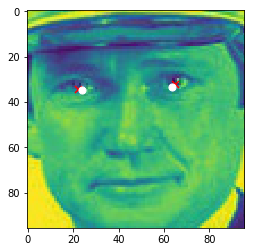

In [18]:
idx = rng.choice(range(len(valid_images)))

image_name = valid_images.iloc[idx]

left_eye_center_x = data.loc[data.image_name == image_name, 'left_eye_center_x']
left_eye_center_y = data.loc[data.image_name == image_name, 'left_eye_center_y']
right_eye_center_x = data.loc[data.image_name == image_name, 'right_eye_center_x']
right_eye_center_y = data.loc[data.image_name == image_name, 'right_eye_center_y']

predicted_left_eye_center_x, predicted_left_eye_center_y, predicted_right_eye_center_x, predicted_right_eye_center_y = predictions[idx]

fig,ax = plt.subplots(1)
img = imread('../datasets/facial_keypoint_identification/images/' + image_name)
ax.imshow(img,cmap='gray')
ax.scatter(left_eye_center_x, left_eye_center_y, marker='x', s=50, c='r')
ax.scatter(right_eye_center_x, right_eye_center_y, marker='x', s=50, c='r')
ax.scatter(predicted_left_eye_center_x, predicted_left_eye_center_y, marker='o', s=50, c='w')
ax.scatter(predicted_right_eye_center_x, predicted_right_eye_center_y, marker='o', s=50, c='w')

plt.show()

print('')